# Tyler's Workspace

First I need to import useful packages

In [1]:
#useful packages to import first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Now I'll need to open some data and read it into a data frame or some other workable form. It will be easiest to open data in the form of csv/tsv. We'll start with Box Office Mojo data.

## Box Office Mojo

In [2]:
# Making a df from Box Office Mojo data
bom_df = pd.read_csv('dsc-phase-1-project-v2-4/zippedData/bom.movie_gross.csv.gz')
# Looking to see if the data was read correctly
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
bom_df.tail()

,title,studio,domestic_gross,foreign_gross,year
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018
3386,An Actor Prepares,Grav.,1700.0,NaN,2018


Everything looks good in the resulting data frames. Now its time look at the data more in-depth. 
We should look at the meta data and summary statistics to get a better idea of what we're working with.

In [4]:
# Looking at the meta data
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


Looks like the quality of the data is alright at first glance. There are lots of missing values from foreign_gross column, but that makes sense if several of the movies only showed in the U.S. foreign_gross also seems not to have been read in as the correct data type. Might as well try and clean that before we use .describe().

In [5]:
# Noticed there was a comma in at least one observation, lets get rid of that
bom_df['foreign_gross'] = bom_df['foreign_gross'].str.replace(",", "")
# Let's see if it worked
bom_df['foreign_gross'] = bom_df['foreign_gross'].astype(float)

In [6]:
# Nice, now we'll have 3 columns of summary stats
bom_df.describe()

,domestic_gross,foreign_gross,year
count,3.359000e+03,2.037000e+03,3387.000000
mean,2.874585e+07,7.487281e+07,2013.958075
std,6.698250e+07,1.374106e+08,2.478141
min,1.000000e+02,6.000000e+02,2010.000000
25%,1.200000e+05,3.700000e+06,2012.000000
50%,1.400000e+06,1.870000e+07,2014.000000
75%,2.790000e+07,7.490000e+07,2016.000000
max,9.367000e+08,9.605000e+08,2018.000000


Looks like the movies are from the year 2000 to 2018, which is good to know. The observations seem to be regularly distributed enough in regard to years. It would be helpful to know total gross income as well which should be easy enough to make. Furthermore, it would be helpful to see the distribution for total gross income to know how much money could be expected. We'll need to join this data with much more data later, but this will be a start.

In [7]:
# Let's make the total gross column and check it out
# First we need to replace Nan with 0, so we don't lose all of our smaller films
bom_df['foreign_gross'].fillna(0, inplace=True)
# If we didn't replace those, we would lose over 1000 values, now we can rest easy
bom_df['total_gross'] = bom_df['domestic_gross'] + bom_df['foreign_gross']
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1.067000e+09
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1.025500e+09
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,9.603000e+08
3,Inception,WB,292600000.0,535700000.0,2010,8.283000e+08
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,7.526000e+08


In [8]:
# DONT RUN THIS TWICE OR IT WILL DIVIDE 'total_gross' TWICE
# It's hard to make meaning out of all these 0's, let's make these numbers more readable
# We'll work with the total gross in millions, this will make the smaller observations less readable,
# but we're trying to compete in the big league. 
bom_df['total_gross'] = bom_df['total_gross'] / 1000000
#Time to rename the col for clarity.
bom_df.rename(columns={'total_gross' : 'total_gross(mil)'}, inplace=True)


In [9]:
# Check it out
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross(mil)
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1067.0
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1025.5
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,960.3
3,Inception,WB,292600000.0,535700000.0,2010,828.3
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,752.6


In [10]:
# There are some numbers we can understand, lets looks at total_gross(mil) closer
bom_df['total_gross(mil)'].describe()

count    3359.000000
mean       74.032508
std       171.109112
min         0.000100
25%         0.273000
50%         5.500000
75%        61.900000
max      1518.900000
Name: total_gross(mil), dtype: float64

Here we are seeing a lot of interesting things. For one, the mean total gross is $74mil compared to a median of $5.5mil. That is a serious positive skew. Also our std and interquartile range are huge. We will try and graph this, but we will probably need to use a logarithmic scale to make sense of it.

(array([2.17e+03, 2.81e+02, 1.78e+02, 1.38e+02, 8.10e+01, 7.00e+01,
        5.40e+01, 4.20e+01, 4.20e+01, 3.20e+01, 2.00e+01, 2.80e+01,
        1.70e+01, 2.60e+01, 1.60e+01, 1.40e+01, 8.00e+00, 7.00e+00,
        9.00e+00, 4.00e+00, 1.60e+01, 6.00e+00, 5.00e+00, 8.00e+00,
        7.00e+00, 7.00e+00, 5.00e+00, 5.00e+00, 8.00e+00, 3.00e+00,
        4.00e+00, 4.00e+00, 4.00e+00, 7.00e+00, 1.00e+00, 1.00e+00,
        5.00e+00, 1.00e+00, 1.00e+00, 5.00e+00, 2.00e+00, 1.00e+00,
        3.00e+00, 1.00e+00, 2.00e+00, 0.00e+00, 1.00e+00, 1.00e+00,
        2.00e+00, 0.00e+00, 2.00e+00, 2.00e+00, 0.00e+00, 1.00e+00,
        0.00e+00, 0.00e+00, 0.00e+00, 1.00e+00]),
 array([1.00000000e-04, 2.61880293e+01, 5.23759586e+01, 7.85638879e+01,
        1.04751817e+02, 1.30939747e+02, 1.57127676e+02, 1.83315605e+02,
        2.09503534e+02, 2.35691464e+02, 2.61879393e+02, 2.88067322e+02,
        3.14255252e+02, 3.40443181e+02, 3.66631110e+02, 3.92819040e+02,
        4.19006969e+02, 4.45194898e+02, 4.71382828

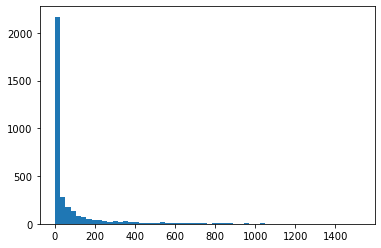

In [23]:
# First we'll set our figure name to grossing_hist
grossing_hist, ax = plt.subplots()
# Now we'll make a histogram of the data, we choose the number of bins by square root of n
ax.hist(bom_df['total_gross(mil)'], bins=round(3359**.5))


(array([  1.,   0.,   0.,   3.,   1.,   1.,   5.,   6.,   3.,   4.,   3.,
         10.,   9.,  18.,  27.,  29.,  39.,  31.,  49.,  41.,  62.,  66.,
         64.,  66.,  83.,  77.,  79.,  80.,  81.,  62.,  82.,  70., 102.,
         77.,  69.,  80., 100.,  73.,  86.,  77.,  90.,  90.,  99., 104.,
         99., 130., 122., 132., 124., 107.,  97.,  87.,  81.,  50.,  48.,
         42.,  28.,  13.]),
 array([-9.21034037, -8.92523551, -8.64013065, -8.35502578, -8.06992092,
        -7.78481606, -7.4997112 , -7.21460633, -6.92950147, -6.64439661,
        -6.35929174, -6.07418688, -5.78908202, -5.50397716, -5.21887229,
        -4.93376743, -4.64866257, -4.36355771, -4.07845284, -3.79334798,
        -3.50824312, -3.22313825, -2.93803339, -2.65292853, -2.36782367,
        -2.0827188 , -1.79761394, -1.51250908, -1.22740421, -0.94229935,
        -0.65719449, -0.37208963, -0.08698476,  0.1981201 ,  0.48322496,
         0.76832982,  1.05343469,  1.33853955,  1.62364441,  1.90874928,
         2.1938541

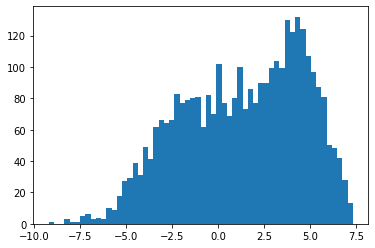

In [25]:
# As expected, we're gonna need to use a logarithmic scale to make any sense of this data
log_of_gross_hist, ax = plt.subplots()
# Here we use the numpy function, log, which will broadcast to the entire series
ax.hist(np.log(bom_df['total_gross(mil)']), bins=round(3359**.5))

This looks much closer to a bell curve, although it is still by no means regular. (Don't be worried by the negative values, this is because many of the smaller films only grossed a fraction of a million dollars). This seems to suggest that as movies get more appealing, the amount of money they make increases exponentially. However, it's hard to say much about what makes a movie appealing giving the limited amount of data we have so far. There also is a pretty large negative skew on this graph, which seems to suggest that it is quite easy to get lumped into the middle with mediocre grossing films. Finally, it's important to take all of these observations with a small mound of salt, given we have have not even taken a peek at the rest of the data yet. 

Another critical thing we should be thinking about is the type of studios we will be competing with. The average movie studio won't have access to the same resources that we have at Microsoft, so we should be sure to whittle down observations to studios we will actually be competing with. It will ultimately be a failure if we invest a fortune into a new studio that fails to compete with other big-name studios with similiar levels of spending. 

In [28]:
# Let's see the studios with the most movies
counts = bom_df['studio'].value_counts()

In [41]:
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year,total_gross(mil)
0,Toy Story 3,BV,415000000.0,652000000.0,2010,1067.0
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010,1025.5
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010,960.3
3,Inception,WB,292600000.0,535700000.0,2010,828.3
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,752.6


In [88]:
# Now we are going to remove all the studios that made less than 10 movies
prolific_counts = counts[counts.values > 10]
print(prolific_counts.index)
# I need to figure this out later
prolific_studios = None

Index(['IFC', 'Uni.', 'WB', 'Fox', 'Magn.', 'SPC', 'Sony', 'BV', 'LGF', 'Par.',
       'Eros', 'Wein.', 'CL', 'Strand', 'FoxS', 'RAtt.', 'KL', 'Focus',
       'WGUSA', 'CJ', 'MBox', 'UTV', 'A24', 'WB (NL)', 'FM', 'LG/S', 'Cohen',
       'ORF', 'Rela.', 'SGem', 'FIP', 'Gold.', 'STX', 'GK', 'RTWC', 'TriS',
       'Osci.', 'BST', 'MNE', 'EOne', 'Drft.', 'Distrib.', 'Anch.', 'Relbig.',
       'CBS', 'Zeit.', 'BG', 'Sum.', 'W/Dim.', 'Yash', 'Trib.', 'FD', 'Orch.',
       'FCW', 'FRun', 'FUN', 'Free', 'Scre.', 'Lorb.', 'Elev.', 'CGld',
       'Vari.', 'PNT'],
      dtype='object')


In [97]:
# Let's group by studio and see which ones make the most
means = bom_df.groupby('studio')['total_gross(mil)'].mean()
high_means = means.sort_values(ascending=False).head(20)
high_means

studio
HC          870.300000
P/DW        507.650000
BV          417.102678
GrtIndia    254.200000
WB (NL)     229.660000
Fox         227.980637
WB          220.256779
Sony        205.549716
Uni.        202.429688
Par.        193.556987
Sum.        152.451400
WAMCR       135.022600
LG/S        132.485951
MGM         104.200000
SGem         90.013200
LGF          84.260615
TriS         80.689348
STX          62.429167
Studio 8     62.050000
W/Dim.       58.260592
Name: total_gross(mil), dtype: float64

In [100]:
sums = bom_df.groupby('studio')['total_gross(mil)'].sum()
high_sums = sums.sort_values(ascending=False).head(20)
high_sums

studio
BV         44212.883899
Fox        31005.366596
WB         30835.948998
Uni.       29757.164191
Sony       22404.919096
Par.       19549.255697
WB (NL)    10334.699999
LGF         8594.582700
LG/S        5431.923998
P/DW        5076.500000
Wein.       4164.636497
SGem        3150.462000
WGUSA       2786.841600
FoxS        2554.419200
Focus       2542.009999
Sum.        2286.771000
CL          1909.200200
TriS        1855.855000
Rela.       1766.172000
STX         1498.300000
Name: total_gross(mil), dtype: float64

In [107]:
# Not sure what all these movie studios are so let's make a dictionary to replace their names
# Google will be our best friend for figuring this out
studio_dict = {'BV': 'Disney', 'WB (NL)': 'WB', 'P/DW': 'Par.'}
# Let's see the movies by the studios and then google the studio
bom_df[bom_df['studio'] == 'HC'].head()
# This studio just has one Chinese propaganda flavored film, we should probably ignore this one
# (unless another movie by the studio comes up)
bom_df[bom_df['studio'] == 'P/DW']
# This one is Paramount Dreamworks, we'll just consider it Paramount
bom_df[bom_df['studio'] == 'GrtIndia']
# Once again just one movie by this studio, we'll ignore it for now

,title,studio,domestic_gross,foreign_gross,year,total_gross(mil)
2796,Baahubali 2: The Conclusion,GrtIndia,20200000.0,234000000.0,2017,254.2


## IMDB

In [43]:
# This is a sqlite database, so we'll need to import sqlite3
import sqlite3

# Me overthinking this crap
# Also, this is a zipped file, so we'll need import zipfile
#import zipfile

In [48]:
#Also me overthinking this crap
#zipfolder = "./dsc-phase-1-project-v2-4/im.db.zip"
#destination = "C:/Users/TWood/Documents/FlatironMaterials/project_1/"
#with zipfile.ZipFile(zipfolder) as file:
#    file.extracttractall(destination)

# Connect to the unzipped db 
con = sqlite3.connect('C:/Users/TWood/Documents/FlatironMaterials/project_1/im.db')

In [54]:
# Make movie_basics data frame
imdb_basics = pd.read_sql("""
SELECT *
FROM movie_basics
""", con)
imdb_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [55]:
# Make movie_ratings df
imdb_ratings = pd.read_sql("""
SELECT *
FROM movie_ratings
""", con)
imdb_ratings

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
...,...,...,...
73851,tt9805820,8.1,25
73852,tt9844256,7.5,24
73853,tt9851050,4.7,14
73854,tt9886934,7.0,5


In [56]:
# We could get a lot more out of these Tables if we joined them
imdb_title_ratings = pd.read_sql("""
SELECT *
FROM movie_basics
JOIN movie_ratings
    USING(movie_id)
""", con)
imdb_title_ratings

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
...,...,...,...,...,...,...,...,...
73851,tt9913084,Diabolik sono io,Diabolik sono io,2019,75.0,Documentary,6.2,6
73852,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,"Drama,Family",8.7,136
73853,tt9914642,Albatross,Albatross,2017,NaN,Documentary,8.5,8
73854,tt9914942,La vida sense la Sara Amat,La vida sense la Sara Amat,2019,NaN,None,6.6,5


In [58]:
imdb_title_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [59]:
imdb_title_ratings.describe()

,start_year,runtime_minutes,averagerating,numvotes
count,73856.000000,66236.000000,73856.000000,7.385600e+04
mean,2014.276132,94.654040,6.332729,3.523662e+03
std,2.614807,208.574111,1.474978,3.029402e+04
min,2010.000000,3.000000,1.000000,5.000000e+00
25%,2012.000000,81.000000,5.500000,1.400000e+01
50%,2014.000000,91.000000,6.500000,4.900000e+01
75%,2016.000000,104.000000,7.400000,2.820000e+02
max,2019.000000,51420.000000,10.000000,1.841066e+06


In [63]:
rated_imdb = imdb_title_ratings[imdb_title_ratings['numvotes'] > 100]

(array([ 177.,  500., 1348., 2526., 4587., 7595., 7864., 3343.,  638.,
          70.]),
 array([1.  , 1.89, 2.78, 3.67, 4.56, 5.45, 6.34, 7.23, 8.12, 9.01, 9.9 ]),
 <BarContainer object of 10 artists>)

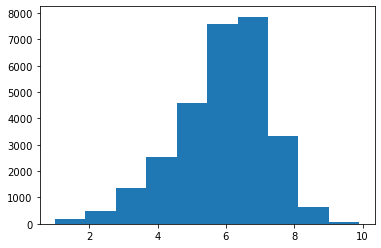

In [64]:
imdb_rating_hist, ax = plt.subplots()
ax.hist(rated_imdb['averagerating'])

In [65]:
con.close()

## Rotten Tomatoes

Here, I'm confused. There are no movie_titles in either file, and while we can technically get some amount of information from this data, we won't figure out a ton. Maybe some of the extra API's and Web scraping they would expect us to do would be data that would flesh out these data frames that are missing valueable data.

In [82]:
rt_info = pd.read_csv('dsc-phase-1-project-v2-4/zippedData/rt.movie_info.tsv.gz', delimiter="\t", compression='gzip')
rt_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [84]:
rt_reviews = pd.read_csv('dsc-phase-1-project-v2-4/zippedData/rt.reviews.tsv.gz', delimiter="\t", encoding='unicode_escape')
rt_reviews

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


## The Movie DB

In [85]:
mdb = pd.read_csv("dsc-phase-1-project-v2-4/zippedData/tmdb.movies.csv.gz", index_col=[0])
mdb

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...
26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [86]:
mdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


In [87]:
mdb.describe()

,id,popularity,vote_average,vote_count
count,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837
std,153661.615648,4.355229,1.852946,960.961095
min,27.000000,0.600000,0.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000
50%,309581.000000,1.374000,6.000000,5.000000
75%,419542.000000,3.694000,7.000000,28.000000
max,608444.000000,80.773000,10.000000,22186.000000


## The Numbers

In [110]:
numbers = pd.read_csv("dsc-phase-1-project-v2-4/zippedData/tn.movie_budgets.csv.gz", index_col=[0])
numbers

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"


In [111]:
numbers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB


In [130]:
numbers['production_clean'] = numbers['production_budget'].str.replace("$", "").str.replace(",", "").astype(float)
numbers['domestic_clean'] = numbers['domestic_gross'].str.replace("$", "").str.replace(",", "").astype(float)
numbers['worldwide_clean'] = numbers['worldwide_gross'].str.replace("$", "").str.replace(",", "").astype(float)
numbers.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,production_clean,domestic_clean,worldwide_clean
id,,,,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",425000000.0,760507625.0,2.776345e+09
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",410600000.0,241063875.0,1.045664e+09
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",350000000.0,42762350.0,1.497624e+08
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",330600000.0,459005868.0,1.403014e+09
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",317000000.0,620181382.0,1.316722e+09


In [131]:
numbers.describe()

,production_clean,domestic_clean,worldwide_clean
count,5.782000e+03,5.782000e+03,5.782000e+03
mean,3.158776e+07,4.187333e+07,9.148746e+07
std,4.181208e+07,6.824060e+07,1.747200e+08
min,1.100000e+03,0.000000e+00,0.000000e+00
25%,5.000000e+06,1.429534e+06,4.125415e+06
50%,1.700000e+07,1.722594e+07,2.798445e+07
75%,4.000000e+07,5.234866e+07,9.764584e+07
max,4.250000e+08,9.366622e+08,2.776345e+09
